In [1]:
import bisect
# go to the parent folder
import os

import matplotlib.pyplot as plt

os.chdir("..")

import numpy as np
import pandas as pd
import time

# Our package
from RB_method_for_model_identification.RBForModelIdentification import RBForModelIdentification

# Inference of real data

In this example, we consider a data set from real experiments. Potentially, the circuit can be described by a three gene-state model as follows:
\begin{align}
&\text{Gene Activation:} && G \to G^* && \text{Propensity:} ~ k_{1} X_G \\
&\text{Gene Deactivation:} && G^* \to G && \text{Propensity:} ~ k_{2} X_{G^*} \\
&\text{Gene Further activation:} && G^* \to G^{**} && \text{Propensity:} ~ k_3 X_{G^*} \\
&\text{Gene Deactivation:} && G^{**} \to G^* && \text{Propensity:} ~ k_4 X_{G^{**}} \\
&\text{mRNA Transcription:} && \emptyset \to \text{mRNA} && \text{Propensity:} ~ k_{p1} X_{G^*} + (k_{p1}+k_{p2}) X_{G^{**}}  \\
&\text{mRNA Degration:} &&\text{mRNA} \to \emptyset && \text{Propensity:} ~ k_d X_\text{mRNA} \\
\end{align}
the gene can transition between three distinct states, with mRNA being produced when the gene is in either of the two activated states. Additionally, the rate of mRNA degradation is directly proportional to its copy number. Also, the mRNA exhibits fluorescence, allowing for the use of a microscope to record its dynamics very 2 minutes.

leader species:  ['G2', 'G1']
follower species:  ['G0', 'mRNA']
follower parameters:  ['k4', 'k1', 'k2', 'kp1', 'kp2', 'k3']


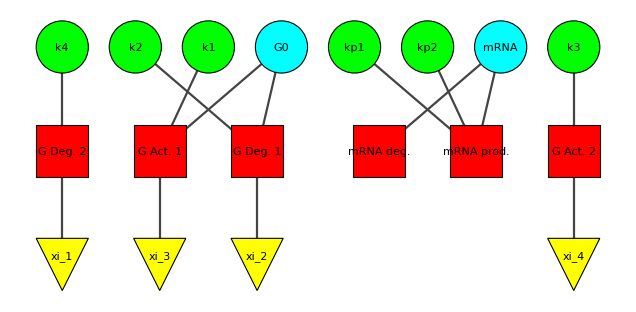

Number of subsystems: 4
-----------------------------------------------------
    xi_1  xi_2  xi_3  xi_4
G2    -1     0     0     1
G1     1    -1     1    -1
-----------------------------------------------------
Subsystem:  1
Involved parameters and species: ['k4']
Unobservable reactions involved: []
Observable reactions involved: ['G Deg. 2']
Xi involved: ['xi_1']
Size of state space of this subsystem: 21
-----------------------------------------------------
Subsystem:  2
Involved parameters and species: ['k2', 'k1', 'G0']
Unobservable reactions involved: []
Observable reactions involved: ['G Act. 1', 'G Deg. 1']
Xi involved: ['xi_3', 'xi_2']
Size of state space of this subsystem: 882
-----------------------------------------------------
Subsystem:  3
Involved parameters and species: ['kp1', 'kp2', 'mRNA']
Unobservable reactions involved: ['mRNA deg.', 'mRNA prod.']
Observable reactions involved: []
Xi involved: []
Size of state space of this subsystem: 18271
------------------------

In [2]:
# The network structure
species_names = ['G0', 'G1', 'G2', 'mRNA']
stoichiometric_matrix = [[-1, 1, 0, 0, 0, 0],
                         [1, -1, -1, 1, 0, 0],
                         [0, 0, 1,-1, 0, 0],
                         [0, 0, 0, 0, 1,-1]]
parameters_names = ['k1','k2', 'k3', 'k4', 'kp1', 'kp2']
reaction_names = ['G Act. 1', 'G Deg. 1', 'G Act. 2', 'G Deg. 2', 'mRNA prod.', 'mRNA deg.']
propensities = [
    lambda k1, G0: k1*G0,
    lambda k2, G1: k2*G1,
    lambda k3, G1: k3*G1,
    lambda k4, G2: k4*G2,
    lambda kp1, kp2, G1, G2: kp1*G1 + (kp1+kp2)*G2,
    lambda mRNA: mRNA
]

range_of_species = \
    pd.DataFrame([[0, 1], [0, 1], [0, 1], [0, 150] ], index=species_names, columns=['min', 'max'])
range_of_parameters= \
    pd.DataFrame([[0, 1], [0, 1], [0, 1], [0, 1], [0, 80], [20, 120]],index=parameters_names,columns=['min', 'max'])
discretization_size_parameters = \
    pd.DataFrame([21, 21, 21, 21, 11, 11], index=parameters_names) #index=parameters_names

# The observation related information
# h_function = [
#     lambda Protein: Protein
# ]
h_function = [
    lambda mRNA: np.where(mRNA > 7, mRNA, 0)
]
observation_noise_intensity = [
    lambda : 1
]
#observation_noise_intensity = {'sigma1': 0.1}

maximum_size_of_each_follower_subsystem = 20000 #800 # 1000


MI = RBForModelIdentification(
    species_names=species_names,
    stoichiometric_matrix=stoichiometric_matrix,
    parameters_names=parameters_names,
    reaction_names=reaction_names,
    propensities=propensities,
    range_of_species=range_of_species,
    range_of_parameters=range_of_parameters,
    observation_noise_intensity=observation_noise_intensity,
    discretization_size_parameters=discretization_size_parameters,
    h_function=h_function,
    maximum_size_of_each_follower_subsystem=maximum_size_of_each_follower_subsystem)

print('leader species: ', MI.leader_species_time_course_data)
print('follower species: ', MI.get_follower_species_time_course_data())
print('follower parameters: ', MI.get_follower_parameters_time_course_data())
MI.leader_follower_decomposition_result_time_course_data.plot_decomposition()

## Load the result

In [3]:
import pickle

# cell index = 78, 18, 20, 39 43, 51, 79, 82, 83, 87, 88, 93, 96, 107, 123, 139

cell_index = 78

# Load the objects from the pickle file
with open(f"Example_of_model_identification/results_in_paper/real_data_cell_index_{cell_index}_particle_number_3000_larger_space.pkl", 'rb') as f:
    data = pickle.load(f)


# Create a new object from the dictionary
Marginal_distributions_over_time = data['margin_distributions_over_time']
time_result = data['time_result']
mean_result = data['mean_result']
std_result = data['std_result']
Y_list = data['Y_list']


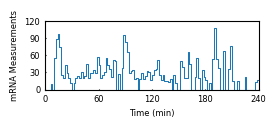

In [4]:
# plot the observation
def cm_to_inch(value):
    return value/2.54

tf =240
dt = 2
Observation_times_list = np.arange(dt, tf+dt, dt)


fig = plt.figure(figsize=(cm_to_inch(7), cm_to_inch(3)))
#plt.step(time_list, np.array(state_list)[:,3],where='post',linewidth=0.75, label='mRNA')
#plt.plot(Observation_times_list, Y_list, 'o', markersize=0.75, label='Measurements')
plt.step(Observation_times_list, Y_list,where='post',linewidth=0.75, label='mRNA')

plt.xlim((0, 240))
plt.ylim((0, 120))
xticks = np.arange(0, 241, step=60)
plt.xticks(xticks)  # Set the x-ticks
plt.xlabel('Time (min)', fontsize=6)
plt.ylabel('mRNA Measurements', fontsize=6)
plt.tick_params(axis='x', labelsize=6, direction='in', length=1)

yticks = np.arange(0, 121, step=30)
plt.yticks(yticks)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

#plt.legend(loc='upper right', fontsize=6)

plt.subplots_adjust(bottom=0.3)

#plt.tight_layout()  # This will ensure everything fits in the figure area

# Save the figure as an EPS file
fig.savefig("figure.eps", format='eps')

In [5]:
mean = np.mean(Y_list)
std = np.std(Y_list)
print(f"mean of the mRNA measurements: {mean}, std of the mRNA measurements: {std}")

mean of the mRNA measurements: 25.959617520037067, std of the mRNA measurements: 23.65400840160905


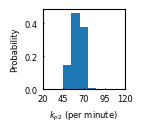

In [6]:
# plot marginal distributions

parameter_species_names = MI.parameters_names + MI.species_names
marginal_distributions = sorted(Marginal_distributions_over_time[-1], key=lambda x: parameter_species_names.index(next(iter(x.parameter_species_ordering))))


# something to change for different plot
marginal_distribution = marginal_distributions[5]
name_to_show = '$k_{p2}$'


distribution = marginal_distribution.distribution_list[-1].copy()
states = marginal_distribution.states.copy()
name = list(marginal_distribution.parameter_species_ordering.keys())[0]


fig = plt.figure(figsize=(cm_to_inch(3), cm_to_inch(3)))

plt.bar(states.reshape(-1), distribution.reshape(-1), width=states[1] - states[0], label='Estimated distribution')
# plt.axvline(x=parameter_values[name], color='r', linestyle='--', label='real value')

plt.xlabel(name_to_show +' (per minute)', fontsize=6)
plt.ylabel('Probability', fontsize=6)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

if name in ['k1', 'k2', 'k3']:
    xticks = np.arange(0, 1.1, step=0.5)
    plt.xlim((0-0.025, 1+0.025))
    yticks = np.arange(0, 0.21, step=0.1)
    #yticks = np.arange(0, 0.91, step=0.3)
elif name in ['k4']:
    xticks = np.arange(0, 2.1, step=1)
    plt.xlim((0-0.1, 1+0.1))
    yticks = np.arange(0, 0.21, step=0.1)
elif name in ['kp1']:
    xticks = np.arange(0, 81, step=20)
    plt.xlim((0, 80))
    #yticks = np.arange(0, 0.61, step=0.2)
    yticks = np.arange(0, 0.91, step=0.3)
else:
    xticks = np.arange(20, 121, step=25)
    plt.xlim((20, 120))
    yticks = np.arange(0, 0.51, step=0.2)


plt.xticks(xticks)  # Set the x-ticks
plt.yticks(yticks)  # Set the x-ticks




# plt.legend(loc='upper left', fontsize=6)



plt.subplots_adjust(bottom=0.2, left= 0.2)



fig.savefig("figure.eps", format='eps')

In [7]:
# compute the stationary distribution of the infreed model

from CRN_Simulation.MarginalDistribution import MarginalDistribution
Initial_marginal_distributions = MI.generate_uniform_marginal_distributions_via_speceis_range(MI.range_of_species)
delta_distribution = np.zeros((len(Initial_marginal_distributions['mRNA'].states), 1))
delta_distribution[0] = 1
Initial_marginal_distributions['mRNA'].adjust_distribution(delta_distribution)
# initial distribution of G0, G1, G2
Initial_marginal_distributions['G0'].adjust_distribution(np.array([[0], [1]]))
Initial_marginal_distributions['G1'].adjust_distribution(np.array([[1], [0]]))
Initial_marginal_distributions['G2'].adjust_distribution(np.array([[1], [0]]))

MAP_parameter_dict = {}
for i in range(len(Marginal_distributions_over_time[-1])):
    element = list(Marginal_distributions_over_time[-1][i].parameter_species_ordering.keys())[0]
    if element in MI.parameters_names:
        map_index = np.argmax(Marginal_distributions_over_time[-1][i].distribution_list[-1])
        map_state = Marginal_distributions_over_time[-1][i].states[map_index, 0]
        MAP_parameter_dict.update({element: map_state})


Tf = 100
distribution_inferred_model = MI.FSP(Initial_marginal_distributions, MI.range_of_species, MAP_parameter_dict, 0, Tf, normalization=True)
marginal_distributions_over_time = distribution_inferred_model.extract_marginal_distributions_over_time()
mRNA_distribution_inferred_model = marginal_distributions_over_time[-1]['mRNA'].distribution
mRNA_distribution_inferred_model = mRNA_distribution_inferred_model.flatten()


dx = 10

bins = np.arange(0, 150, dx)
data_distribution= [0]*len(bins)
for i in range(len(bins)-1):
    for j in range(5, len(Y_list)):
        if bins[i] <= Y_list[j] < bins[i+1]:
            data_distribution[i] += 1
data_distribution = np.array(data_distribution)/sum(data_distribution)


new_distribution= [0]*len(bins)

for i in range(len(bins)-1):
    for j in range(len(mRNA_distribution_inferred_model)):
        if bins[i] <= j < bins[i+1]:
            new_distribution[i] += mRNA_distribution_inferred_model[j]

x = [x+dx/2 for x in bins]

weights = np.ones_like(Y_list) / len(Y_list)
# plt.hist(np.array(Y_list[5:]).reshape(-1), weights=weights, bins=bins, edgecolor='black', alpha=0.75, label='data')
x = [x+dx/2 for x in bins]


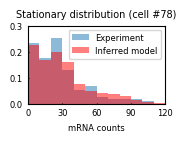

In [8]:
fig = plt.figure(figsize=(cm_to_inch(4.5), cm_to_inch(3)))
#fig = plt.figure(figsize=(cm_to_inch(5), cm_to_inch(3)))
plt.bar(x, data_distribution, width=dx, alpha=0.5, label='Experiment')

plt.bar(x, new_distribution, color='red', width=dx, alpha=0.5, label='Inferred model')
# plt.plot(x, new_distribution, color='red', label='inferred')

plt.legend(loc='upper right', fontsize=6)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

plt.xlabel( 'mRNA counts', fontsize=6)
# plt.ylabel('Probability', fontsize=6)
plt.title(f'Stationary distribution (cell #{cell_index})', fontsize=7)
#plt.title(f'Stationary distribution', fontsize=7)

xticks = np.arange(0, 121, step=30)
plt.xticks(xticks)  # Set the x-ticks
plt.xlim((0, 120))
yticks = np.arange(0, 0.31, step=0.1)
plt.yticks(yticks)  # Set the x-ticks

plt.subplots_adjust(bottom=0.22)

fig.savefig("figure.pdf", format='pdf')

In [9]:
from scipy.stats import entropy

kl_divergence = entropy(data_distribution, new_distribution)
print('KL-divergence:', kl_divergence)

KL-divergence: 0.03139576194766626


In [10]:
# the sensitivity of the parameters

from tqdm import tqdm

MAP_parameter_dict = {}
for i in range(len(Marginal_distributions_over_time[-1])):
    element = list(Marginal_distributions_over_time[-1][i].parameter_species_ordering.keys())[0]
    if element in MI.parameters_names:
        map_index = np.argmax(Marginal_distributions_over_time[-1][i].distribution_list[-1])
        map_state = Marginal_distributions_over_time[-1][i].states[map_index, 0]
        MAP_parameter_dict.update({element: map_state})


distribution_real_model = MI.FSP(Initial_marginal_distributions, MI.range_of_species, MAP_parameter_dict, 0, Tf, normalization=True)
time, real_expectation_list = distribution_real_model.expectation()
real_mRNA_mean = real_expectation_list[-1]['mRNA']

Mean_changed = {}
for parameter in tqdm(MI.parameters_names):
    new_parameter_values = MAP_parameter_dict.copy()
    new_parameter_values[parameter] = 1.1*MAP_parameter_dict[parameter]
    distribution_perturbed_model = MI.FSP(Initial_marginal_distributions, MI.range_of_species, new_parameter_values, 0, Tf, normalization=True)
    time, changed_expectation_list = distribution_perturbed_model.expectation()
    Mean_changed.update({parameter: changed_expectation_list[-1]['mRNA']})

elasticity = {}
for parameter in MI.parameters_names:
    elasticity.update({parameter: (Mean_changed[parameter] - real_mRNA_mean)/real_mRNA_mean/0.1})

print('Elasticity:', elasticity)

  0%|          | 0/6 [00:14<?, ?it/s]


KeyboardInterrupt: 

In [11]:
# Number of measured cells
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.stats import poisson

file_name = 'Example_of_model_identification/real_data/data45.mat'
real_data = sio.loadmat(file_name)

measured_cell_indexes = []

for cell_index in range(len(real_data['cellTrajectory'][0])):
    mRNA_trjectatory = real_data['cellTrajectory'][0,cell_index][0,0][0]/73
    Observation_times_list= list(range(2, len(mRNA_trjectatory)*2, 2))
    if len(mRNA_trjectatory) > 5:
        measured_cell_indexes.append(cell_index)

print('Number of measured cells:', len(measured_cell_indexes))
print('Cell Indexes:', measured_cell_indexes)

Number of measured cells: 130
Cell Indexes: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 57, 59, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 87, 88, 89, 90, 91, 93, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 145, 146, 147, 148, 150, 151, 152, 153, 154, 155, 156, 157, 158]


## Plot the figures for noise analysis

In [12]:
import pickle

# Load the objects from the pickle file
with open(f"Example_of_model_identification/results_in_paper/noise_analysis.pkl", 'rb') as f:
    data = pickle.load(f)


# Create a new object from the dictionary
measured_cell_indexes = data['measured_cell_indexes']
parameters_MAP_list = data['parameters_MAP_list']
stationary_mean_real_cell_list = data['stationary_mean_real_cell_list']
stationary_mean_inferred_mode_list = data['stationary_mean_inferred_mode_list']
stationary_variance_real_cell_list = data['stationary_variance_real_cell_list']
stationary_variance_inferred_mode_list = data['stationary_variance_inferred_mode_list']
time = data['time']
mean_inferred_model_over_time_list = data['mean_inferred_model_over_time_list']
variance_inferred_model_over_time_list = data['variance_inferred_model_over_time_list']
mRNA_real_cell_over_time_list = data['mRNA_real_cell_over_time_list']


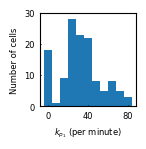

In [13]:
# Plot the MAP estimates among the cells
def cm_to_inch(value):
    return value/2.54

# something to change for different plot
parameter_name = 'kp1'
name_to_show = '$k_{p_1}$'


if parameter_name in ['k1', 'k2', 'k3']:
    bins = np.arange(0-0.025, 1.026, 0.05)
elif parameter_name in ['k4']:
    bins = np.arange(0-0.05, 2.06, 0.1)
elif parameter_name in ['kp1']:
    bins = np.arange(0-4, 85, 8)
elif parameter_name in ['kp2']:
    bins = np.arange(20-5, 121+5, 10)

data = [ element[parameter_name] for element in parameters_MAP_list]

fig = plt.figure(figsize=(cm_to_inch(3.5), cm_to_inch(3.5)))

plt.hist(data, bins=bins)

if parameter_name in ['kp1']:
    xticks = np.arange(0, 81, step=40)
    plt.xticks(xticks)  # Set the x-ticks
    plt.yticks(np.arange(0, 31, step=10))  # Set the y-ticks
if parameter_name in ['kp2']:
    xticks = np.arange(20, 121, step=50)
    plt.xticks(xticks)  # Set the x-ticks

plt.xlabel(name_to_show +' (per minute)', fontsize=6)
plt.ylabel('Number of cells', fontsize=6)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)






plt.subplots_adjust(bottom=0.2, left= 0.2)

fig.savefig("figure.eps", format='eps')


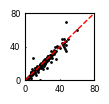

In [14]:
# plot the stationary mean of real cells and inferred model

fig = plt.figure(figsize=(cm_to_inch(2.5), cm_to_inch(2.5)))

plt.plot(stationary_mean_real_cell_list, stationary_mean_inferred_mode_list, 'o', markersize=1, color='black')
plt.plot([0, 100], [0, 100], '--', color='red', linewidth=1)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

xticks = np.arange(0, 81, step=40)
plt.xticks(xticks)  # Set the x-ticks
plt.yticks(xticks)  # Set the y-ticks
plt.xlim(0, 80)
plt.ylim(0, 80)

#plt.xlabel('Value by measurements', fontsize=6)
#plt.ylabel('Value by inferred models', fontsize=6)
#plt.title('Stationary mean of mRNA', fontsize=6)

plt.subplots_adjust(bottom=0.2, left= 0.2)
fig.savefig("figure.eps", format='eps')

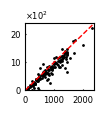

In [15]:
# plot the stationary variance of real cells and inferred model

import matplotlib.ticker as ticker

# fig = plt.figure(figsize=(cm_to_inch(3), cm_to_inch(3)))
fig, ax = plt.subplots(figsize=(cm_to_inch(2.5), cm_to_inch(2.5)))


plt.plot(stationary_variance_real_cell_list, stationary_variance_inferred_mode_list, 'o', markersize=1, color='black')
plt.plot([0, 3000], [0, 3000], '--', color='red', linewidth=1)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 1e-2:.0f}'))  # Scale y-ticks by 1e-2
ax.text(0, 1.05, r'$\times10^2$', transform=ax.transAxes, fontsize=6)

xticks = np.arange(0, 2200, step=1000)
plt.xticks(xticks)  # Set the x-ticks
plt.yticks(xticks)  # Set the y-ticks
plt.xlim(0, 2400)
plt.ylim(0, 2400)

#plt.xlabel('Value by measurements', fontsize=6)
#plt.ylabel('Value by inferred models', fontsize=6)
#plt.title('Stationary mean of mRNA', fontsize=6)

plt.subplots_adjust(bottom=0.2, left= 0.2)
fig.savefig("figure.eps", format='eps')

In [24]:
count = 0
for i in range(len(stationary_variance_real_cell_list)):
    if stationary_variance_real_cell_list[i]*0.88 > stationary_variance_inferred_mode_list[i]:
        count += 1
print('Number of cells with larger variance in real cells:', count)

Number of cells with larger variance in real cells: 66


In [25]:
# linear regression for the stationary variance
from sklearn.linear_model import LinearRegression

X = np.array(stationary_variance_real_cell_list).reshape(-1, 1)
y = np.array(stationary_variance_inferred_mode_list).reshape(-1, 1)

reg = LinearRegression().fit(X, y)

print('R^2:', reg.score(X, y))

R^2: 0.873072418673553


intrinsic_noise_real_cell 837.5288220487333
extrinsic_noise_real_cell 163.59919658713764
intrinsic_noise_inferred_model 729.3472808234346
extrinsic_noise_inferred_model 179.8459855700079


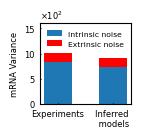

In [17]:
# plot the decomposition of variance at staionary distribution

import matplotlib.ticker as ticker

# fig = plt.figure(figsize=(cm_to_inch(4), cm_to_inch(3)))
fig, ax = plt.subplots(figsize=(cm_to_inch(3.5), cm_to_inch(3)))

intrinsic_noise_inferred_model = np.mean(stationary_variance_inferred_mode_list)
extrinsic_noise_inferred_model = np.var(stationary_mean_inferred_mode_list)
intrinsic_noise_real_cell = np.mean(stationary_variance_real_cell_list)
extrinsic_noise_real_cell = np.var(stationary_mean_real_cell_list)

lower_part = [intrinsic_noise_real_cell, intrinsic_noise_inferred_model]
upper_part = [extrinsic_noise_real_cell, extrinsic_noise_inferred_model]

# draw lower bars
p1 = plt.bar([0, 1], lower_part, width=0.5, color='C0', label='Intrinsic noise')

# draw upper bars
p2 = plt.bar([0, 1], upper_part, bottom=lower_part, width=0.5, color='r', label='Extrinsic noise')

plt.xticks([0, 1], ['Experiments', 'Inferred \n models'], fontsize=6)
plt.ylabel('mRNA Variance', fontsize=6)

plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

yticks = np.arange(0, 1600, step=500)
ax.set_yticks(yticks)  # Set the y-ticks

#plt.xlim(-0.5, 1.5)
plt.ylim(0, 1600)

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{x * 1e-2:.0f}'))  # Scale y-ticks by 1e-2
ax.text(0, 1.05, r'$\times10^2$', transform=ax.transAxes, fontsize=6)



plt.legend(loc='upper right', fontsize=5.5, frameon=False)

plt.subplots_adjust(bottom=0.2, left= 0.24)
fig.savefig("figure.eps", format='eps')

print('intrinsic_noise_real_cell', intrinsic_noise_real_cell)
print('extrinsic_noise_real_cell', extrinsic_noise_real_cell)
print('intrinsic_noise_inferred_model', intrinsic_noise_inferred_model)
print('extrinsic_noise_inferred_model', extrinsic_noise_inferred_model)


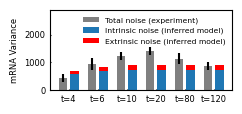

In [19]:
# noise decomposition over time
intrinsic_noise_inferred_model = np.mean(variance_inferred_model_over_time_list, axis=0)
extrinsic_noise_inferred_model = np.var(mean_inferred_model_over_time_list, axis=0)
Variance_experimental = np.var(mRNA_real_cell_over_time_list, axis=0)

# error in estimating the experimental noise
from sklearn.utils import resample
data_whole = np.array(mRNA_real_cell_over_time_list)
error_bar = []
for t in range(data_whole.shape[1]):
    data = data_whole[:, t]
    n_iterations = 1000
    bootstrap_variances = np.zeros(n_iterations)
    for i in range(n_iterations):
        bootstrap_sample = resample(data)
        bootstrap_variances[i] = np.var(bootstrap_sample)

    error_bar.append( np.std(bootstrap_variances) )
error_bar = np.array(error_bar)


index = [1,2,3,4,6, 7]
x = np.arange(len(index))

fig = plt.figure(figsize=(cm_to_inch(7), cm_to_inch(3)))

plt.bar(x - 0.2, Variance_experimental[index], width=0.3, color='grey', label='Total noise (experiment)', yerr=error_bar[index])
plt.bar(x + 0.2, intrinsic_noise_inferred_model[index], width=0.3, color='C0', label='Intrinsic noise (inferred model)')
plt.bar(x + 0.2, extrinsic_noise_inferred_model[index], bottom=intrinsic_noise_inferred_model[index], width=0.3, color='r', label='Extrinsic noise (inferred model)')

plt.ylim(0, 2000)


xticks_values = ['t='+ str(time[i]) for i in index]
plt.xticks(x, xticks_values, fontsize=6)
yticks = np.arange(0, 2100, step=1000)
plt.ylim(0, 2900)
plt.yticks(yticks)  #
plt.tick_params(axis='x', labelsize=6, direction='in', length=1)
plt.tick_params(axis='y', labelsize=6, direction='in', length=1)

plt.ylabel('mRNA Variance', fontsize=6)


plt.legend(loc='upper right', fontsize=5.5, frameon=False, ncol=1)


plt.subplots_adjust(bottom=0.2, left= 0.24)
fig.savefig("figure.eps", format='eps')
